##  Phase 1: Date Normalization

In [9]:
import pandas as pd
from datetime import datetime

# Define the file paths and corresponding company names or tickers
file_paths = {
    'Apple': 'C:/Users/Beab/Desktop/Kifiya AIM/Data/yfinance_data/AAPL_historical_data.csv',
    'Amazon': 'C:/Users/Beab/Desktop/Kifiya AIM/Data/yfinance_data/AMZN_historical_data.csv',
    'Google': 'C:/Users/Beab/Desktop/Kifiya AIM/Data/yfinance_data/GOOG_historical_data.csv',
    'Meta': 'C:/Users/Beab/Desktop/Kifiya AIM/Data/yfinance_data/META_historical_data.csv',
    'Microsoft': 'C:/Users/Beab/Desktop/Kifiya AIM/Data/yfinance_data/MSFT_historical_data.csv',
    'Nvidia': 'C:/Users/Beab/Desktop/Kifiya AIM/Data/yfinance_data/NVDA_historical_data.csv',
    'Tesla': 'C:/Users/Beab/Desktop/Kifiya AIM/Data/yfinance_data/TSLA_historical_data.csv',
}

# Load news dataset
news_df = pd.read_csv('raw_analyst_ratings.csv')

# Create an empty dictionary to hold the DataFrames for each company
stock_data = {}

# Loop through the file paths and read each CSV file into a DataFrame
for company, file_path in file_paths.items():
    stock_data[company] = pd.read_csv(file_path)

# 1.1 Convert Date Columns to Same Format for News and Stock Data
# Handle various date formats with 'coerce' to avoid issues with inconsistent formats
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce').dt.strftime('%Y-%m-%d')

# Convert stock data dates to the same format
for company, df in stock_data.items():
    df['date'] = pd.to_datetime(df['Date'], errors='coerce').dt.strftime('%Y-%m-%d')  # Assuming the column name is 'Date'

# 1.2 Filter out non-trading days from the news data by aligning dates
# Only keep news dates that are present in the stock data
for company, df in stock_data.items():
    news_df = news_df[news_df['date'].isin(df['date'])]

# Check for missing or inconsistent dates
for company, df in stock_data.items():
    missing_dates = set(news_df['date']) - set(df['date'])
    if missing_dates:
        print(f"Missing Dates in {company}: ", missing_dates)

# Example to show the first few rows of the DataFrame for 'Apple'
print(stock_data['Apple'].head())



         Date      Open      High       Low     Close  Adj Close     Volume  \
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   Dividends  Stock Splits        date  
0        0.0           0.0  1980-12-12  
1        0.0           0.0  1980-12-15  
2        0.0           0.0  1980-12-16  
3        0.0           0.0  1980-12-17  
4        0.0           0.0  1980-12-18  


## Phase 2: Sentiment Analysis

In [11]:
!pip install nltk textblob

  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/626.3 kB 325.1 kB/s eta 0:00:02
   - ------------------------------------- 30.7/626.3 kB 325.1 kB/s eta 0:00:02
   --- ----------------------------------- 61.4/626.3 kB 272.3 kB/s eta 0:00:03
   ----- --------------------------------- 92.2/626.3 kB 348.6 kB/s eta 0:00:02
   ----- --------------------------------- 92.2/626.3 kB 348.6 kB/s eta 0:00:02
   -------- ----------------------------- 143.4/626.3 kB 387.0 kB/s eta 0:00:02
   ---------- ------------

In [12]:
from textblob import TextBlob
import nltk
nltk.download('punkt')

# 2.1 Perform Sentiment Analysis
def get_sentiment(headline):
    analysis = TextBlob(headline)
    # Categorize sentiment as positive, negative, or neutral
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity < 0:
        return -1
    else:
        return 0

news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# 2.2 Aggregate Sentiment Scores by Date
aggregated_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
aggregated_sentiment.columns = ['date', 'avg_sentiment']

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Beab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Phase 3: Stock Movement Calculation

In [16]:
# Loop through each company's DataFrame in the stock_data dictionary
for company, df in stock_data.items():
    # Compute Daily Stock Returns
    df['daily_return'] = df['Close'].pct_change()  # Assuming 'Close' is the column name for closing prices
    
    # Verify the results by checking a few rows for each company
    print(f"Daily Returns for {company}:")
    print(df[['Date', 'Close', 'daily_return']].head(10))

Daily Returns for Apple:
         Date     Close  daily_return
0  1980-12-12  0.128348           NaN
1  1980-12-15  0.121652     -0.052171
2  1980-12-16  0.112723     -0.073398
3  1980-12-17  0.115513      0.024751
4  1980-12-18  0.118862      0.028992
5  1980-12-19  0.126116      0.061029
6  1980-12-22  0.132254      0.048670
7  1980-12-23  0.137835      0.042199
8  1980-12-24  0.145089      0.052628
9  1980-12-26  0.158482      0.092309
Daily Returns for Amazon:
         Date     Close  daily_return
0  1997-05-15  0.097917           NaN
1  1997-05-16  0.086458     -0.117028
2  1997-05-19  0.085417     -0.012040
3  1997-05-20  0.081771     -0.042685
4  1997-05-21  0.071354     -0.127392
5  1997-05-22  0.069792     -0.021891
6  1997-05-23  0.075000      0.074622
7  1997-05-27  0.079167      0.055560
8  1997-05-28  0.076563     -0.032892
9  1997-05-29  0.075260     -0.017019
Daily Returns for Google:
         Date     Close  daily_return
0  2004-08-19  2.499133           NaN
1  2004-08-

## Phase 4: Correlation Analysis

Pearson Correlation between Sentiment and Stock Returns for Apple: -0.005906770850743059


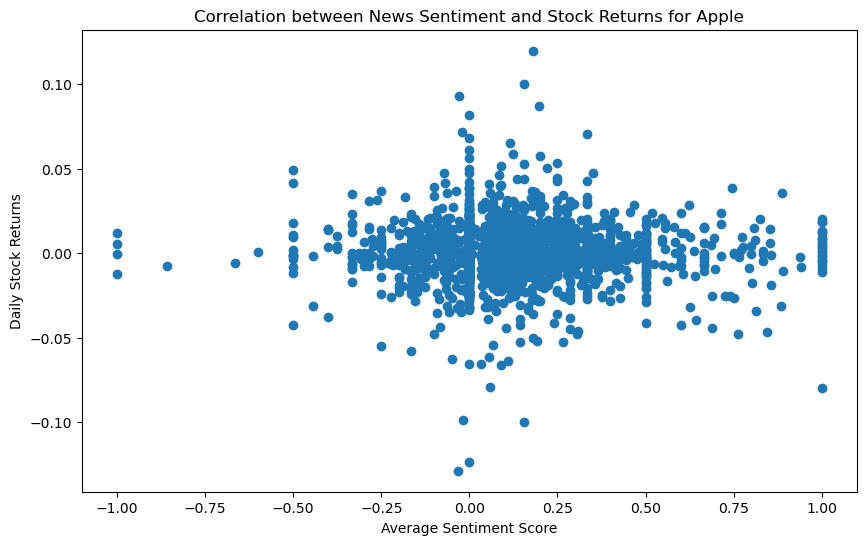

Pearson Correlation between Sentiment and Stock Returns for Amazon: -0.036303714714083675


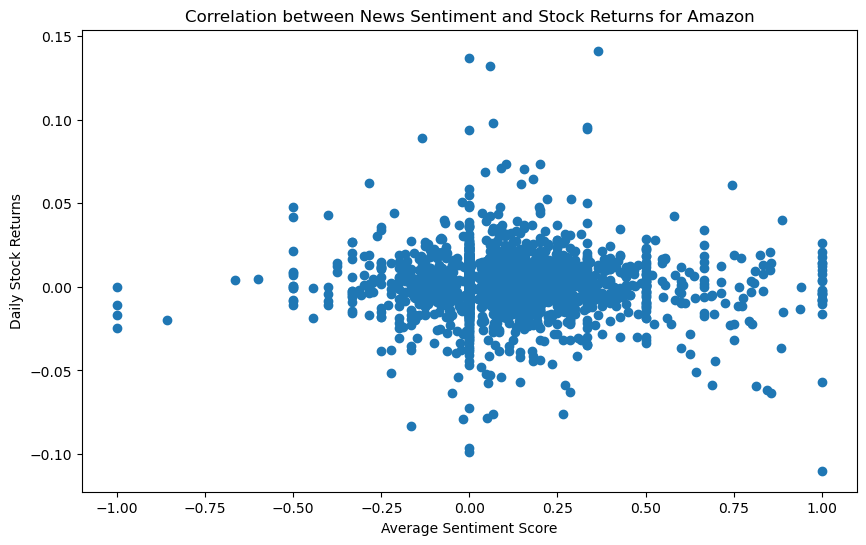

Pearson Correlation between Sentiment and Stock Returns for Google: 0.005009184702044695


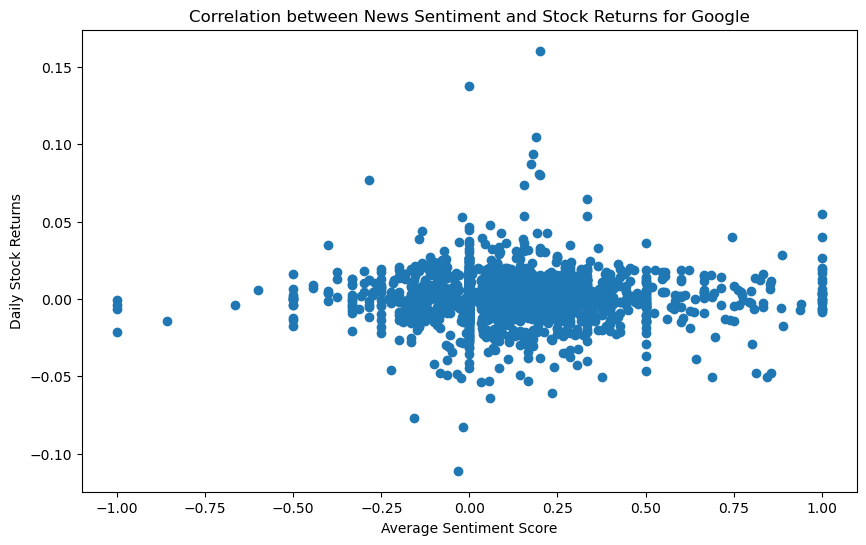

Pearson Correlation between Sentiment and Stock Returns for Meta: 0.0040211547279113925


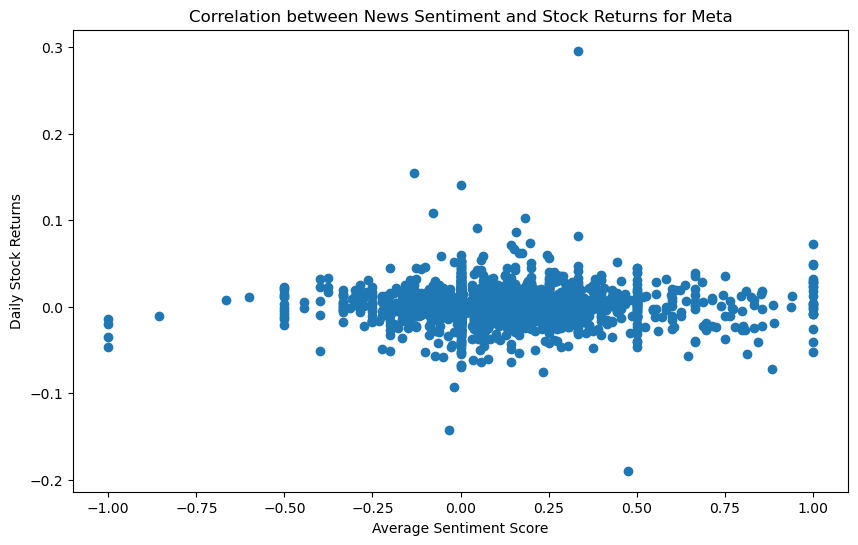

Pearson Correlation between Sentiment and Stock Returns for Microsoft: -0.024622405130828372


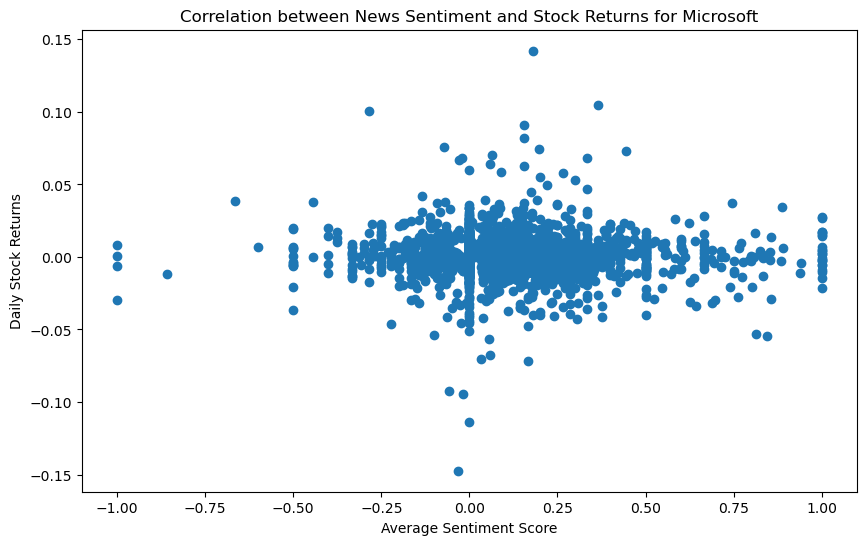

Pearson Correlation between Sentiment and Stock Returns for Nvidia: -0.022563903313552534


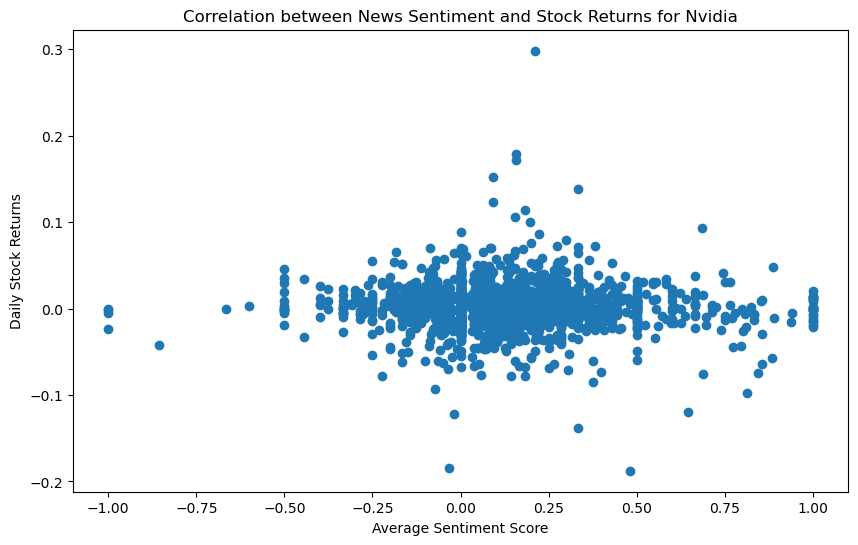

Pearson Correlation between Sentiment and Stock Returns for Tesla: -0.0011129557492297656


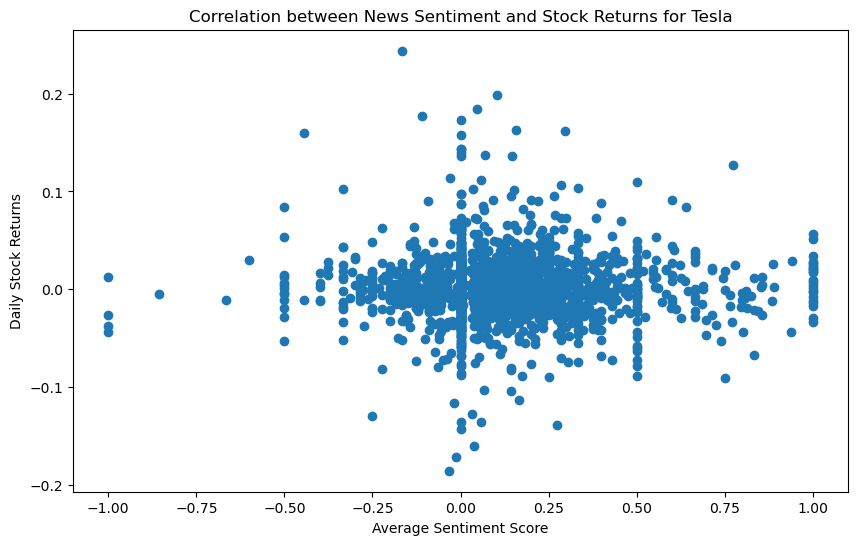

In [20]:
# Assuming 'aggregated_sentiment' is the DataFrame containing the aggregated sentiment scores by date
# Ensure 'aggregated_sentiment' DataFrame exists with 'date' and 'avg_sentiment' columns
import matplotlib.pyplot as plt
for company, df in stock_data.items():
    # Align Datasets by Date
    merged_df = pd.merge(aggregated_sentiment, df[['Date', 'daily_return']], left_on='date', right_on='Date')
    
    # Drop the redundant 'Date' column after merging
    merged_df.drop(columns=['Date'], inplace=True)

    # Calculate Correlation
    correlation = merged_df['avg_sentiment'].corr(merged_df['daily_return'])
    print(f"Pearson Correlation between Sentiment and Stock Returns for {company}: {correlation}")

    # Visualize the Correlation
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_df['avg_sentiment'], merged_df['daily_return'])
    plt.title(f'Correlation between News Sentiment and Stock Returns for {company}')
    plt.xlabel('Average Sentiment Score')
    plt.ylabel('Daily Stock Returns')
    plt.show()